# 載入資料

In [ ]:
!gdown --id '1rKgQnFdmzUEnVMHog75myo_oJ8zFSzr1' --output 'cabbage.xlsx'
!gdown --id '1-2GdInJS8I5QOO3nJCKC9Bc6YG2j6o5m' --output 'weather.csv'

# 安裝套件

In [ ]:
%%capture
!pip install prophet
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from prophet import Prophet

In [ ]:
%%capture
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# 檢視資料

## 甘藍

,price,quantity
date,,
2012-01-06,23.57,218433
2012-01-05,28.06,198807
2012-01-04,29.82,197525
2012-01-03,31.60,224420
2012-01-01,35.66,162014


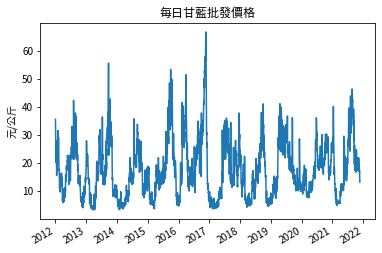

In [ ]:
df_c = pd.read_excel('cabbage.xlsx', index_col='date', parse_dates=True)
display(df_c.tail())
df_c.price.plot()
plt.title('每日甘藍批發價格')
plt.ylabel('元/公斤')
plt.xlabel('')
plt.show()

In [ ]:
df_c['pq'] = df_c.price * df_c.quantity
df_c = df_c.resample('W').sum()
df_c.price = df_c.pq / df_c.quantity
df_c = df_c.drop(columns=['quantity', 'pq'])

,price
date,
2021-10-31,20.232946
2021-11-07,19.820345
2021-11-14,19.742776
2021-11-21,17.500035
2021-11-28,13.270000


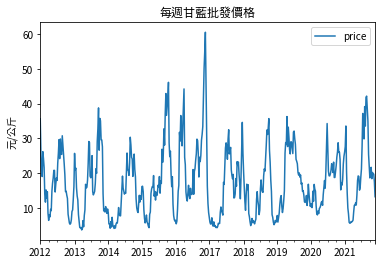

In [ ]:
display(df_c.tail())
df_c.plot()
plt.title('每週甘藍批發價格')
plt.ylabel('元/公斤')
plt.xlabel('')
plt.show()

## 天氣

In [ ]:
cols = ['ObsTime', 'Temperature', 'Precp']
df_w = pd.read_csv('weather.csv', usecols=cols, index_col='ObsTime', parse_dates=True)
df_w.index.name = 'date' # ℃、mm
df_w.head()

,Temperature,Precp
date,,
2012-01-01,15.1,0.0
2012-01-02,15.5,0.0
2012-01-03,16.1,0.0
2012-01-04,11.0,2.0
2012-01-05,12.3,13.0


In [ ]:
df_w = df_w.resample('W').mean()
df_w.tail()

,Temperature,Precp
date,,
2021-11-07,24.085714,0.071429
2021-11-14,18.614286,6.000000
2021-11-21,22.900000,0.785714
2021-11-28,18.885714,2.857143
2021-12-05,22.300000,1.000000


## 合併

In [ ]:
df = pd.merge(df_c, df_w, how='outer', left_index=True, right_index=True)
df = df.dropna()
print(df.shape)
df.tail()

(518, 3)


,price,Temperature,Precp
date,,,
2021-10-31,20.232946,22.957143,0.428571
2021-11-07,19.820345,24.085714,0.071429
2021-11-14,19.742776,18.614286,6.000000
2021-11-21,17.500035,22.900000,0.785714
2021-11-28,13.270000,18.885714,2.857143


In [ ]:
# df['price'] = np.log(df.price)
df['ln_price'] = np.log(df.price)

In [ ]:
print(df.isna().sum())

price          0
Temperature    0
Precp          0
ln_price       0
dtype: int64


# 切割資料集

In [ ]:
# Validation
val_df = df[-31:]

# Training
df = df[:-31]

# 資料分析

## Visualization

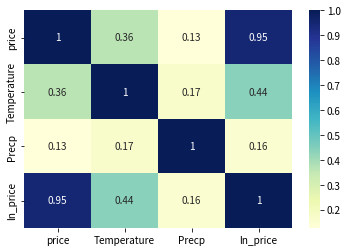

In [ ]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.show()

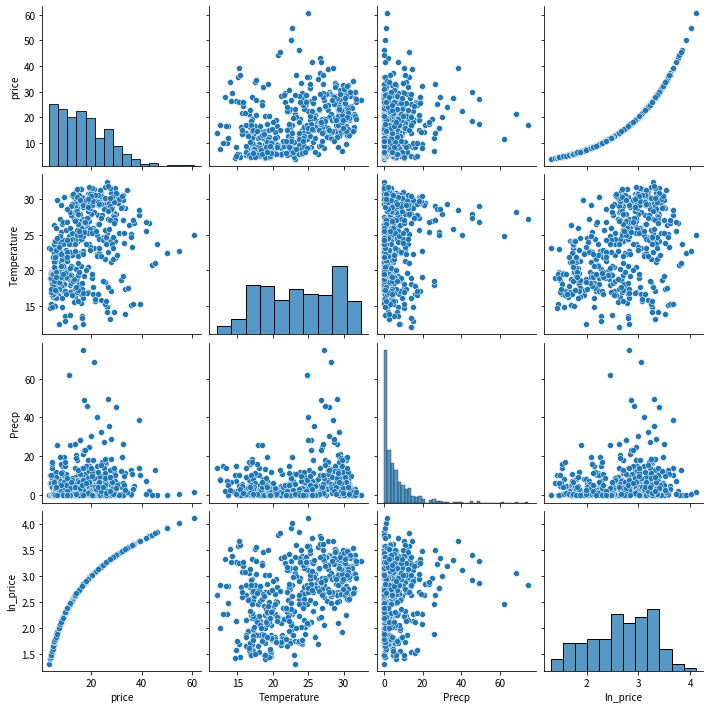

In [ ]:
sns.pairplot(df)
plt.show()

## Decompose

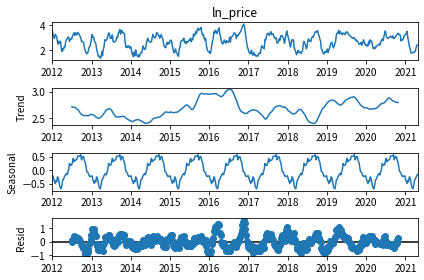

In [ ]:
decomp_results = seasonal_decompose(df.ln_price)
decomp_results.plot()
plt.show()

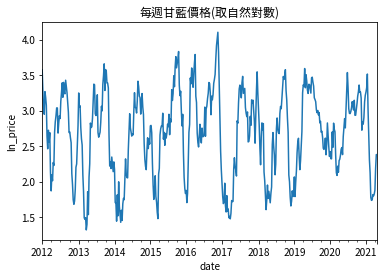

In [ ]:
df.ln_price.plot()
plt.title('每週甘藍價格(取自然對數)')
plt.ylabel('ln_price')
plt.show()

## ADF TEST

In [ ]:
# print(adfuller(df.price))
print(adfuller(df.ln_price))

(-5.8374322113665205, 3.8471137598010745e-07, 2, 484, {'1%': -3.4439333076538854, '5%': -2.8675301216074414, '10%': -2.56996050355167}, -131.38165806041218)


## ACF與PACF

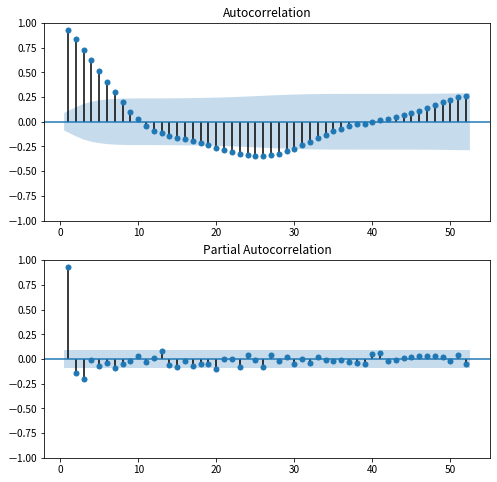

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

# Make ACF plot
plot_acf(df.ln_price, lags=52, zero=False, ax=ax1)

# Make PACF plot
plot_pacf(df.ln_price, lags=52, zero=False, ax=ax2, method='ywm')
plt.show()

# 模型

## SARIMAX
$SARIMAX(p, d, q) \times (P, D, Q): Seasonal + ARIMA + Exogenous$

$AR(p): Y_t = \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \dots + \beta_pY_{t-p} + u_t$

$MR(q): Y_t = \theta_0 + \theta_1u_{t-1} + \theta_2u_{t-2} + \dots + \theta_qu_{t-q} + u_t$

$ARIMR(p, d, q): (1 - \sum_{i=1}^p \beta_i L^i)(1-L)^dY_t = (1 - \sum_{i=1}^q \theta_i L^i)u_t$, where $L$ stands for Lag operator.

In [ ]:
# result = pm.auto_arima(df.ln_price, X=df[['Temperature', 'Precp']], seasonal=True, m=12, D=1)

In [ ]:
%%capture
model = SARIMAX(df.ln_price, exog=df[['Temperature', 'Precp']],
                order=(3,0,0), seasonal_order=(2, 1, 0, 12))
result = model.fit()

In [ ]:
print(result.summary())
# WEEK:  SARIMAX(3, 0, 0)x(2, 1, 0, 12) 
# MONTH: SARIMAX(2, 0, 0)x(2, 1, 0, 12)

                                     SARIMAX Results                                      
Dep. Variable:                           ln_price   No. Observations:                  487
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                  -4.789
Date:                            Mon, 03 Jan 2022   AIC                             25.578
Time:                                    07:42:43   BIC                             58.884
Sample:                                01-01-2012   HQIC                            38.676
                                     - 04-25-2021                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.0100      0.004     -2.432      0.015      -0.018      -0.002
Precp           0.0022      0.00

### 樣本內(訓練資料)預測

In [ ]:
predicted = result.get_prediction(start=-10)
mean = predicted.predicted_mean
conf1 = predicted.conf_int(alpha=0.32)  # 68%
conf2 = predicted.conf_int(alpha=0.05)  # 95%

In [ ]:
mean = np.exp(predicted.predicted_mean)

conf1 = np.exp(conf1)
conf1.columns = ['lower price', 'upper price']

conf2 = np.exp(conf2)
conf2.columns = ['lower price', 'upper price']

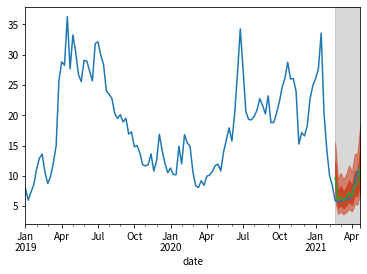

In [ ]:
fig, ax = plt.subplots()
df['2019':'2021'].price.plot(ax=ax, legend=False)
df['2021':].price.plot(style=' ', ax=ax, legend=False)
mean.plot()
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.3)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='xkcd:tomato red', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='xkcd:tomato red', alpha=0.6, facecolor='black')
plt.show()

### 樣本外(測試資料)預測

In [ ]:
forecast = result.get_forecast(steps=len(val_df), exog=val_df[['Temperature', 'Precp']])
conf1 = forecast.conf_int(alpha=0.32)  # 68%
conf2 = forecast.conf_int(alpha=0.05)  # 95%

In [ ]:
mean = np.exp(forecast.predicted_mean).append(df.price[-1:]).sort_index()
lastp = df[['price', 'price']][-1:]
lastp.columns = ['lower price', 'upper price']
lastp.index.name = 'ds'

In [ ]:
conf1 = np.exp(conf1)
conf1.columns = ['lower price', 'upper price']
conf1 = conf1.append(lastp).sort_index()

conf2 = np.exp(conf2)
conf2.columns = ['lower price', 'upper price']
conf2 = conf2.append(lastp).sort_index()

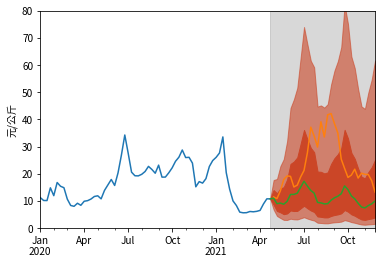

In [ ]:
fig, ax = plt.subplots()
df['2020':'2021'].price.plot(ax=ax, legend=False)
val_df.price.plot()
mean.plot()
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.3)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='xkcd:tomato red', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='xkcd:tomato red', alpha=0.6, facecolor='black')
ax.set_xlabel('')
ax.set_ylabel('元/公斤')
ax.set_ylim(0, 80)
plt.show()

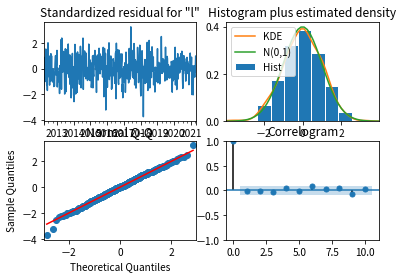

In [ ]:
result.plot_diagnostics() # pm.auto_arima(df, seasonal=True, m=7)
plt.show()

## fbporphet
$y(t) = g(t) + s(t) + h(t) + e(t)$

$g(t)$: trend models non-periodic changes.

$s(t)$: seasonality presents periodic changes.

$h(t)$: effects of holidays with irregular schedules.

$e(t)$: covers idiosyncratic changes not accommodated by the model.

### 設定資料

In [ ]:
dfp = df.reset_index()
dfp.columns = ['ds', 'price', 'Temperature', 'Precp', 'ln_price']
dfp['y'] = dfp.ln_price
dfp.tail()

,ds,price,Temperature,Precp,ln_price,y
482,2021-03-28,6.200022,19.128571,4.285714,1.824553,1.824553
483,2021-04-04,6.547962,24.528571,0.000000,1.879154,1.879154
484,2021-04-11,8.901299,19.571429,0.071429,2.186197,2.186197
485,2021-04-18,10.802403,21.857143,0.000000,2.379769,2.379769
486,2021-04-25,10.794229,24.242857,0.000000,2.379012,2.379012


In [ ]:
val_dfp = val_df.reset_index()
val_dfp.columns = ['ds', 'price', 'Temperature', 'Precp', 'ln_price']

### 樣本內(訓練資料)預測

In [ ]:
m = Prophet(seasonality_mode='multiplicative', daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'Temperature', 'Precp']])

predict = m.make_future_dataframe(periods=0, freq='W', include_history=True)
predict['Temperature'] = df[['Temperature']].reset_index(drop=True)
predict['Precp'] = df[['Precp']].reset_index(drop=True)

fcst0 = m.predict(predict)
fcst0 = fcst0.set_index(fcst0.ds, drop=True)

### 樣本外(測試資料)預測

#### 68%信賴區間

In [ ]:
m = Prophet(seasonality_mode='multiplicative', interval_width=0.68, daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'Temperature', 'Precp']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W', include_history=False)
future['Temperature'] = val_dfp[['Temperature']]
future['Precp'] = val_dfp[['Precp']]

fcst1 = m.predict(future)
fcst1 = fcst1.set_index(fcst1.ds, drop=True)
# fig = m.plot(fcst)

#### 95%信賴區間

In [ ]:
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95, daily_seasonality=False, weekly_seasonality=True)
m.add_regressor('Temperature')
m.add_regressor('Precp')
m.fit(dfp[['ds', 'y', 'Temperature', 'Precp']])

future = m.make_future_dataframe(periods=len(val_dfp), freq='W', include_history=False)
future['Temperature'] = val_dfp[['Temperature']]
future['Precp'] = val_dfp[['Precp']]

fcst2 = m.predict(future)
fcst2 = fcst2.set_index(fcst2.ds, drop=True)
# fig = m.plot(fcst)

#### 彙整

In [ ]:
mean = np.exp(fcst1.yhat).append(df.price[-1:]).sort_index()

conf1 = np.exp(fcst1[['yhat_lower', 'yhat_upper']])
conf1.columns = ['lower price', 'upper price']
conf1 = conf1.append(lastp).sort_index()

conf2 = np.exp(fcst2[['yhat_lower', 'yhat_upper']])
conf2.columns = ['lower price', 'upper price']
conf2 = conf2.append(lastp).sort_index()

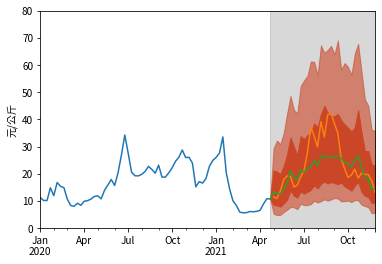

In [ ]:
fig, ax = plt.subplots()
df['2020':'2021'].price.plot(ax=ax, legend=False)
val_df.price.plot()
mean.plot()
plt.axvspan(mean.index.min(), mean.index.max(), color='grey', alpha=0.3)
plt.fill_between(conf1.index, conf1['lower price'], conf1['upper price'], color='xkcd:tomato red', facecolor='black')
plt.fill_between(conf2.index, conf2['lower price'], conf2['upper price'], color='xkcd:tomato red', alpha=0.6, facecolor='black')
ax.set_xlabel('')
ax.set_ylabel('元/公斤')
ax.set_ylim(0, 80)
plt.show()

# 評估

## 準備評估資料

### 訓練資料(樣本內資料)

In [ ]:
dfins = pd.DataFrame({'y_real': df.price,
                      'y_sarimax': np.exp(result.get_prediction().predicted_mean),
                      'y_prophet': np.exp(fcst0.yhat)})
print(dfins.shape)
dfins.tail()

(487, 3)


,y_real,y_sarimax,y_prophet
2021-03-28,6.200022,7.284556,9.128244
2021-04-04,6.547962,6.598011,8.598740
2021-04-11,8.901299,8.462989,10.947746
2021-04-18,10.802403,8.532042,11.383364
2021-04-25,10.794229,11.448555,11.732135


### 測試資料(樣本外資料)

In [ ]:
dfoos = pd.DataFrame({'y_real': val_df.price,
                      'y_sarimax': np.exp(forecast.predicted_mean),
                      'y_prophet': np.exp(fcst1.yhat)})
print(dfoos.shape)
dfoos.head()

(31, 3)


,y_real,y_sarimax,y_prophet
2021-05-02,11.513150,11.037208,13.204348
2021-05-09,10.888260,9.023718,12.891188
2021-05-16,13.741941,9.248901,12.620266
2021-05-23,17.934376,8.820206,14.250324
2021-05-30,19.239293,9.864164,16.838564


## [評估標準](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

*   $\mbox{MSE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T(Y_t - \widehat{Y}_t)^2$

*   $\mbox{MAE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T|Y_t - \widehat{Y}_t|$

*   $\mbox{MAPE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T\frac{|Y_t - \widehat{Y}_t|}{max(u_t, |Y_t|)}$


## 樣本內評估

In [ ]:
mse = [mean_squared_error(dfins.y_real, dfins.y_sarimax),
       mean_squared_error(dfins.y_real, dfins.y_prophet)]
mae = [mean_absolute_error(dfins.y_real, dfins.y_sarimax),
       mean_absolute_error(dfins.y_real, dfins.y_prophet)]
mape = [mean_absolute_percentage_error(dfins.y_real, dfins.y_sarimax),
        mean_absolute_percentage_error(dfins.y_real, dfins.y_prophet)]
dfv_ins = pd.DataFrame({'MSE': mse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_ins

,MSE,MAE,MAPE
SARIMAX,32.315823,3.708209,0.222998
prophet,66.917979,5.721954,0.375757


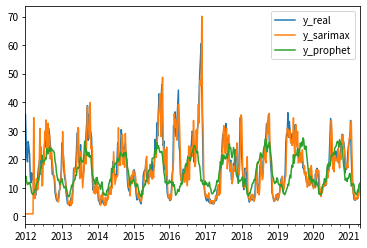

In [ ]:
dfins.plot()
plt.show()

## 樣本外評估

In [ ]:
mse = [mean_squared_error(dfoos.y_real, dfoos.y_sarimax),
       mean_squared_error(dfoos.y_real, dfoos.y_prophet)]
mae = [mean_absolute_error(dfoos.y_real, dfoos.y_sarimax),
       mean_absolute_error(dfoos.y_real, dfoos.y_prophet)]
mape = [mean_absolute_percentage_error(dfoos.y_real, dfoos.y_sarimax),
      mean_absolute_percentage_error(dfoos.y_real, dfoos.y_prophet)]
dfv_oos = pd.DataFrame({'MSE': mse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_oos

,MSE,MAE,MAPE
SARIMAX,248.729522,12.629552,0.464582
prophet,48.872483,5.216640,0.193029


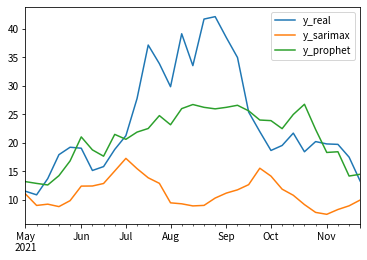

In [ ]:
dfoos.plot()
plt.show()

In [ ]:
# for Question
mse = [mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
       mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
mae = [mean_absolute_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
       mean_absolute_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
mape = [mean_absolute_percentage_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
      mean_absolute_percentage_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
dfv_oos = pd.DataFrame({'MSE': mse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_oos

,MSE,MAE,MAPE
SARIMAX,0.676048,0.707594,0.217708
prophet,0.061002,0.207330,0.064588
